## Introduction to TensorRT

In this Jupyter notebook, we embark on a fascinating journey to explore the performance and efficiency gains achieved by leveraging TensorRT, NVIDIA's deep learning inference optimizer, in image classification tasks. We begin by using a pre-trained ResNet model in PyTorch to perform simple image classification on a delightful hotdog image. After obtaining the classification results, we delve into the world of optimization, converting the PyTorch model to the ONNX format, and further optimizing it using TensorRT to harness the true potential of NVIDIA GPUs.

Through this step-by-step process, we uncover how TensorRT performs extensive optimizations, such as layer fusion and half-precision (FP16) computation, to speed up inference without compromising accuracy. With the TensorRT engine in hand, we then venture into the realm of real-time inference, comparing the outputs between PyTorch and TensorRT to ensure the preservation of classification accuracy.

But the journey does not end there! We also conduct a performance evaluation, quantifying the time difference between PyTorch and TensorRT for inference on the same hotdog image. Through latency comparisons, we witness the significant speedup achieved by TensorRT, demonstrating its prowess in accelerating deep learning models for real-world applications.

Intriguing insights and exciting revelations await as we unleash the power of TensorRT and embrace the future of fast, efficient, and accurate image classification. Let's embark on this adventure and discover the wonders of PyTorch and TensorRT!


### Step 1 : Pure Pytorch Inference

In [1]:
from torchvision import models
import cv2
import torch
from torchvision.transforms import Resize, Compose, ToTensor, Normalize

/home/sanket/anaconda3/envs/tensorrt/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def preprocess_image(img_path):
    # transformations for the input data
    transforms = Compose([
        ToTensor(),
        Resize(224),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    # read input image
    input_img = cv2.imread(img_path)
    # do transformations
    input_data = transforms(input_img)
    batch_data = torch.unsqueeze(input_data, 0)
    return batch_data

def postprocess(output_data):
    # get class names
    with open("../data/imagenet-classes.txt") as f:
        classes = [line.strip() for line in f.readlines()]
    # calculate human-readable value by softmax
    confidences = torch.nn.functional.softmax(output_data, dim=1)[0] * 100
    # find top predicted classes
    _, indices = torch.sort(output_data, descending=True)
    i = 0
    # print the top classes predicted by the model
    while confidences[indices[0][i]] > 50:
        class_idx = indices[0][i]
        print(
            "class:",
            classes[class_idx],
            ", confidence:",
            confidences[class_idx].item(),
            "%, index:",
            class_idx.item(),
        )
        i += 1

In [3]:
input = preprocess_image("../data/hotdog.jpg").cuda()
model = models.resnet50(pretrained=True)
model.eval()
model.cuda()
output = model(input)

postprocess(output)

/home/sanket/anaconda3/envs/tensorrt/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/sanket/anaconda3/envs/tensorrt/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


class: hotdog, hot dog, red hot , confidence: 60.50566864013672 %, index: 934


#### Compute Average Latency of Pure Pytorch Inference

In [4]:
import time

# Pure PyTorch Inference
def pytorch_inference(model, input):
    start_time = time.time()
    output = model(input)
    end_time = time.time()
    return output, (end_time - start_time)

# Number of iterations
num_iterations = 10

# Run Pure PyTorch Inference for 1000 iterations
total_pytorch_latency = 0
for i in range(num_iterations):
    with torch.no_grad():
        output, latency = pytorch_inference(model, input)
        total_pytorch_latency += latency
average_pytorch_latency = (total_pytorch_latency / num_iterations) * 1000
torch.cuda.empty_cache()

### Step 2 : Convert Pytorch model to ONNX

In [5]:
ONNX_FILE_PATH = '../deploy_tools/resnet.onnx'
torch.onnx.export(model, input, ONNX_FILE_PATH, input_names=['input'],
                  output_names=['output'], export_params=True)



### Step 3 : Convert ONNX to TensorRT Engine

In [6]:
import pycuda.driver as cuda
import pycuda.autoinit
import numpy as np
import tensorrt as trt


In [8]:
TRT_LOGGER = trt.Logger(trt.Logger.WARNING)
builder = trt.Builder(TRT_LOGGER)

[07/23/2023-14:25:23] [TRT] [W] CUDA lazy loading is not enabled. Enabling it can significantly reduce device memory usage and speed up TensorRT initialization. See "Lazy Loading" section of CUDA documentation https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#lazy-loading


In [9]:
EXPLICIT_BATCH = 1 << (int)(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)
network = builder.create_network(1 << int(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH), )

In [11]:
parser = trt.OnnxParser(network, TRT_LOGGER)
success = parser.parse_from_file(ONNX_FILE_PATH)
for idx in range(parser.num_errors):
    print(parser.get_error(idx))


In [12]:
config = builder.create_builder_config()
config.set_memory_pool_limit(trt.MemoryPoolType.WORKSPACE, 1 << 22) # 1 MiB
config.set_flag(trt.BuilderFlag.FP16)

In [13]:
serialized_engine = builder.build_serialized_network(network, config)

[07/23/2023-14:26:32] [TRT] [W] TensorRT encountered issues when converting weights between types and that could affect accuracy.
[07/23/2023-14:26:32] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to adjust the magnitude of the weights.
[07/23/2023-14:26:32] [TRT] [W] Check verbose logs for the list of affected weights.
[07/23/2023-14:26:32] [TRT] [W] - 80 weights are affected by this issue: Detected subnormal FP16 values.
[07/23/2023-14:26:32] [TRT] [W] - 37 weights are affected by this issue: Detected values less than smallest positive FP16 subnormal value and converted them to the FP16 minimum subnormalized value.


In [14]:
with open("../deploy_tools/resnet.engine", "wb") as f:
    f.write(serialized_engine)

### Step 4 : Run Inference on TensorRT Engine

In [18]:
runtime = trt.Runtime(TRT_LOGGER)

with open("../deploy_tools/resnet.engine", "rb") as f:
    serialized_engine = f.read()
    
engine = runtime.deserialize_cuda_engine(serialized_engine)

context = engine.create_execution_context()

[07/23/2023-14:28:36] [TRT] [W] CUDA lazy loading is not enabled. Enabling it can significantly reduce device memory usage and speed up TensorRT initialization. See "Lazy Loading" section of CUDA documentation https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#lazy-loading


In [19]:
# Determine dimensions and create page-locked memory buffers (i.e. won't be swapped to disk) to hold host inputs/outputs.
h_input = cuda.pagelocked_empty(trt.volume(engine.get_binding_shape(0)), dtype=np.float32)
h_input = cuda.pagelocked_empty(trt.volume(engine.get_binding_shape(0)), dtype=np.float32)
h_output = cuda.pagelocked_empty(trt.volume(engine.get_binding_shape(1)), dtype=np.float32)
# Allocate device memory for inputs and outputs.
d_input = cuda.mem_alloc(h_input.nbytes)
d_output = cuda.mem_alloc(h_output.nbytes)
# Create a stream in which to copy inputs/outputs and run inference.
stream = cuda.Stream()

/tmp/ipykernel_9240/3786040357.py:2: DeprecationWarning: Use get_tensor_shape instead.
  h_input = cuda.pagelocked_empty(trt.volume(engine.get_binding_shape(0)), dtype=np.float32)
/tmp/ipykernel_9240/3786040357.py:3: DeprecationWarning: Use get_tensor_shape instead.
  h_input = cuda.pagelocked_empty(trt.volume(engine.get_binding_shape(0)), dtype=np.float32)
/tmp/ipykernel_9240/3786040357.py:4: DeprecationWarning: Use get_tensor_shape instead.
  h_output = cuda.pagelocked_empty(trt.volume(engine.get_binding_shape(1)), dtype=np.float32)


In [20]:
host_input = np.array(preprocess_image("../data/hotdog.jpg").numpy(), dtype=np.float32, order='C')
# Transfer input data to the GPU.
cuda.memcpy_htod_async(d_input, host_input, stream)
# Run inference.
context. execute_async_v2(bindings=[int(d_input), int(d_output)], stream_handle=stream.handle)
# Transfer predictions back from the GPU.
cuda.memcpy_dtoh_async(h_output, d_output, stream)
# Synchronize the stream
stream.synchronize()


In [21]:
tensorrt_output = torch.Tensor(h_output).unsqueeze(0)

In [22]:
postprocess(tensorrt_output)

class: hotdog, hot dog, red hot , confidence: 60.48761749267578 %, index: 934


#### Compute Error in Output between Pure Torch and TensorRT

In [24]:
# Calculate MAE between pure torch output and TensorRT inference output
mae = torch.mean(torch.abs(output.cpu() - tensorrt_output))
print("MAE:", mae.item())

MAE: 0.005440928041934967


#### Measure TensorRT Inference Average Latency

In [25]:
# calculate latency
import time
import torch

# TensorRT FP16 Inference
def tensorrt_inference(context, d_input, d_output, host_input):
    start_time = time.time()
    cuda.memcpy_htod_async(d_input, host_input, stream)
    context.execute_async_v2(bindings=[int(d_input), int(d_output)], stream_handle=stream.handle)
    cuda.memcpy_dtoh_async(h_output, d_output, stream)
    stream.synchronize()
    tensorrt_output = torch.Tensor(h_output).unsqueeze(0)
    end_time = time.time()
    return tensorrt_output, (end_time - start_time)


In [32]:
# Number of iterations
num_iterations = 10

# Run TensorRT FP16 Inference for 1000 iterations
total_tensorrt_latency = 0
for _ in range(num_iterations):
    with torch.no_grad():
        tensorrt_output, latency = tensorrt_inference(context, d_input, d_output, host_input)
        total_tensorrt_latency += latency
average_tensorrt_latency = (total_tensorrt_latency / num_iterations) * 1000

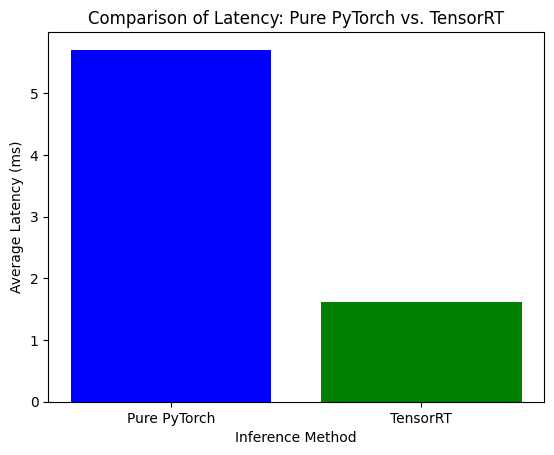

In [28]:
from matplotlib import pyplot as plt

latencies = [average_pytorch_latency, average_tensorrt_latency]
labels = ['Pure PyTorch', 'TensorRT']

# Create a bar chart
plt.bar(labels, latencies, color=['blue', 'green'])

# Add labels and title
plt.xlabel('Inference Method')
plt.ylabel('Average Latency (ms)')
plt.title('Comparison of Latency: Pure PyTorch vs. TensorRT')

# Show the plot
plt.show()
